In [ ]:
import numpy as np                                
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from sklearn.decomposition import PCA

Using TensorFlow backend.


# Augmentation

170500096/170498071 [==============================] - 6s 0us/step
Original images examples


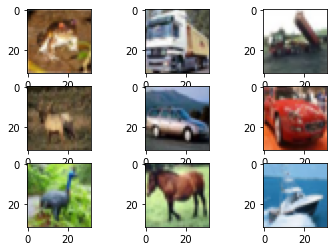

Augmentated images examples


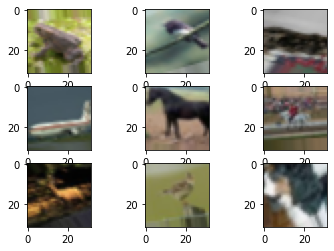

Randomly augmentated images examples


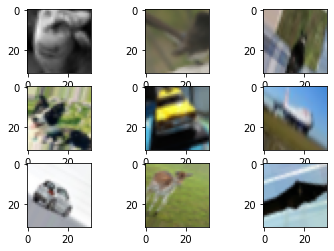

In [ ]:
#load data
(x_train, y_train), (x_test, y_test_a) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
print('Original images examples')
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

# Number of rows of the dataset
number_of_rows = x_train.shape[0]

# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3,
    )
datagen.fit(x_train)

# see example augmentation images
print('Augmentated images examples')
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size = number_of_rows):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

# Combine original with augmentated
x_train_aug_a = np.concatenate((x_train, X_batch.astype(np.uint8)), axis=0)
y_train_aug_a = np.concatenate((y_train, y_batch.astype(np.uint8)), axis=0)

num_classes = len(np.unique(y_train))

x_train_aug = x_train_aug_a.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train_aug = keras.utils.to_categorical(y_train_aug_a, num_classes)
y_test = keras.utils.to_categorical(y_test_a, num_classes)

# Select 10% randomly from training data
new_size = int(number_of_rows*0.1)
random_indices = np.random.choice(number_of_rows, size = new_size, replace=False)
x_train_random = x_train[random_indices, :]
y_train_random = y_train[random_indices, :]

datagen.fit(x_train_random)

# see example of randomly augmentation images
print('Randomly augmentated images examples')
for X_batch_random, y_batch_random in datagen.flow(x_train_random, y_train_random, batch_size=new_size):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch_random[i].astype(np.uint8))
    plt.show()
    break

# Combine original with augmentated
x_train_random_aug_a = np.concatenate((x_train_random, X_batch_random.astype(np.uint8)), axis=0)
y_train_random_aug_a = np.concatenate((y_train_random, y_batch_random.astype(np.uint8)), axis=0)

x_train_random_aug = x_train_random_aug_a.astype('float32') / 255.

y_train_random_aug = keras.utils.to_categorical(y_train_random_aug_a, num_classes)

x_train = x_train.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train, num_classes)

x_train_ransom = x_train_random.astype('float32') / 255.
y_train_random = keras.utils.to_categorical(y_train_random, num_classes)

x_train_aug , y_train_aug = shuffle(x_train_aug,y_train_aug)
x_train_random_aug, y_train_random_aug = shuffle(x_train_random_aug,y_train_random_aug)

# Data Reduction

PCA on the original data 

In [ ]:
x_train_flat_50000 = x_train.reshape(-1,3072)
pca = PCA(0.95)
pca.fit(x_train_flat_50000)
train_img_pca_50000 = pca.transform(x_train_flat_50000) #  The train PCA output
x_test_flat = x_test.reshape(-1,3072)
test_img_pca = pca.transform(x_test_flat) #  The test PCA output
print(pca.n_components_) 

217


# Feature Extraction

Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, CuDNNLSTM, Reshape
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.objectives import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

Validation Split

In [ ]:
x_trainf, x_validf, y_trainf, y_validf = train_test_split(x_train_random_aug, y_train_random_aug, test_size=0.2, random_state=42, shuffle= True)

Necessary functions

In [ ]:
def create_block(input, chs): # Creating a 2D convolutional block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

# computing  the class weights for using in convolutional model. 
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(y_trainf), 
                y_trainf.reshape(y_trainf.size))

Autoencoder Model

In [ ]:
def general_ae():
    input = Input((32,32,3))
    
    # Encoder layer
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    
    #Middle layer
    x = MaxPool2D(2)(block2)
    middle = create_block(x, 128)
    
    # Decoder layer
    block3 = create_block(middle, 64)
    up1 = UpSampling2D((2,2))(block3)
    block4 = create_block(up1, 32)
    up2 = UpSampling2D((2,2))(block4)
    
    # output layer
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

def loss_function(y_true, y_pred):  # loss function for using in autoencoder models
    mses = mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

Implementing AE

In [ ]:
encoder_ae, model_ae = general_ae()
model_ae.compile(SGD(1e-3, 0.9), loss=loss_function)

In [ ]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
history = model_ae.fit(x_trainf, x_trainf, 
                       batch_size=512,
                       epochs=100,
                       verbose=1,
                       validation_data=(x_validf, x_validf),
                       shuffle=True, callbacks=callbacks,
                       class_weight=class_weights)

In [ ]:
recon_train_ae = model_ae.predict(x_trainf)
recon_valid_ae = model_ae.predict(x_validf)
recon_test_ae = model_ae.predict(x_test)

Extracting bottleneck features to use as inputs in the classifier model

In [ ]:
gist_train_ae = encoder_ae.predict(x_trainf)
gist_valid_ae = encoder_ae.predict(x_validf)
gist_test_ae = encoder_ae.predict(x_test)

Classifier Models

In [ ]:
def classifier_conv(inp):
    input = Input((inp.shape[1], inp.shape[2], inp.shape[3]))
    x = Conv2D(1024, 3, padding="same")(input)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(128, 3, padding="same")(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.35)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.69)(x)
    output = Dense(10, activation='softmax')(x)
    return Model(input, output)

Convolutional AE with convolutional NN as classifier

In [ ]:
decoder_ae_conv = classifier_conv(gist_train_ae)
decoder_ae_conv.compile(loss='categorical_crossentropy',
                        optimizer=Adadelta(),
                        metrics=['accuracy'])
decoder_ae_conv.summary()

In [ ]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist1 = decoder_ae_conv.fit(gist_train_ae, y_trainf, batch_size=512, epochs=100, 
                            validation_data = (gist_valid_ae, y_validf),
                            shuffle=True, callbacks=callbacks,
                            class_weight=class_weights)

Flattening The Outputs

In [ ]:
recon_train_ae_flat = recon_train_ae.reshape(8000, 3072)
recon_valid_ae_flat = recon_valid_ae.reshape(2000, 3072)
recon_test_ae_flat = recon_test_ae.reshape(10000, 3072)

gist_train_ae_flat = gist_train_ae.reshape(8000, 8192)
gist_valid_ae_flat = gist_valid_ae.reshape(2000, 8192)
gist_test_ae_flat = gist_test_ae.reshape(10000, 8192)

# y sets are: y_trainf, y_validf, y_test

# Hyperparameter Tuning & Result

Libraries

In [ ]:

import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import regularizers, initializers
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools

Functions

In [ ]:

def create_model(conv_filters, conv_stack,
                 dense_layer_sizes,
                 kernel_size,
                 optimizer, init='he_normal'):
# Create the model
    model = Sequential()
    
    # First stack of Conv - separate because of the input_shape shape
    model.add(Conv2D(input_shape=(32, 32, 3), 
                 filters=conv_filters[0], 
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu',
                 kernel_initializer=init,
                 bias_initializer='zeros'))
    for stack in range(conv_stack-1) :
       model.add(Conv2D(filters=conv_filters[0], 
                     kernel_size=kernel_size,
                     padding='same',
                     activation='relu',
                     kernel_initializer=init,
                     bias_initializer='zeros')) 
       model.add(Dropout(0.25))
      
    # FC layers
    model.add(Flatten())
    for layer_size in dense_layer_sizes:
    
        model.add(Dense(units=layer_size, 
                        activation='relu',
                        kernel_initializer=init,
                        bias_initializer='zeros',
                        kernel_regularizer=regularizers.l2(0.0001)))
        model.add(Dropout(0.5))
    #model.add(keras.layers.normalization.BatchNormalization(axis=-1))
    model.add(Dense(num_classes, activation='softmax'))
    
    for opt in optimizer:
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #optimizer={{choice(['rmsprop', 'adam', 'sgd'])}}
    print(model.summary())
    return model


def model_creation(dense_layer_sizes,
                   optimizer,i_dim):
  
  model = Sequential()

  model.add(Dense(dense_layer_sizes[0],
                  input_dim = i_dim,
                  activation='relu',
                  kernel_initializer='he_normal',
                  bias_initializer='zeros',
                  kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.25))
  
  for layer_size in dense_layer_sizes[1:]:
    model.add(Dense(layer_size, 
                    activation='relu',
                    kernel_initializer='he_normal',
                    bias_initializer='zeros',
                    kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.25))
    
  model.add(Dense(num_classes, activation='softmax'))
    

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  print(model.summary())
  return model


def show_confusion_matrix(y_test, y_pred):
  
  Y_pred = np.argmax(y_pred, axis=1)
  Y_test = np.argmax(y_test, axis=1)

  cm = confusion_matrix(Y_test, Y_pred)

  np.set_printoptions(precision=2)
  plt.figure()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()

  class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=90)
  plt.yticks(tick_marks, class_names)

  fmt =  'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")


  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

  return

def show_train_history(history):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()
  return

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

Original data Hyperparamters Tuning 

In [ ]:

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


# Normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

# One hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]



optimizers = [['adam'],['rmsprop']]
init = ['he_normal']
epochs = [10]
batches = [64,128]
cv_stack = [2]
kl_size = [(3,3),(5,5)]
cv_filters =[[64]]
dense_size_candidates = [[512, 256],[256,512,256],[128, 512]]

param_grid = dict(optimizer=optimizers,
                  epochs=epochs, 
                  batch_size=batches, 
                  init=init,
                  conv_filters=cv_filters,
                  conv_stack=cv_stack,
                  kernel_size=kl_size,
                  dense_layer_sizes=dense_size_candidates)

#%% Model and Grid creation & Running
model = KerasClassifier(build_fn=create_model, verbose=2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2,verbose=2)
grid_result = grid.fit(x_train, y_train)

#%% Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Using the best Hyperparamters for original dataset

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               33554944  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

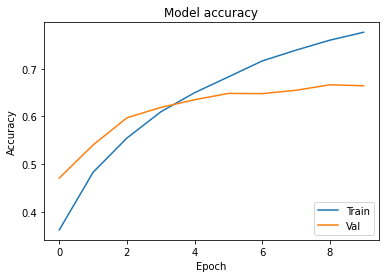

Classification Report
              precision    recall  f1-score   support

    airplane       0.72      0.72      0.72      1000
  automobile       0.76      0.83      0.79      1000
        bird       0.61      0.47      0.53      1000
         cat       0.48      0.48      0.48      1000
        deer       0.57      0.66      0.61      1000
         dog       0.60      0.42      0.49      1000
        frog       0.65      0.78      0.71      1000
       horse       0.74      0.72      0.73      1000
        ship       0.80      0.79      0.79      1000
       truck       0.69      0.79      0.73      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000

classification accuracy = 0.6644999980926514


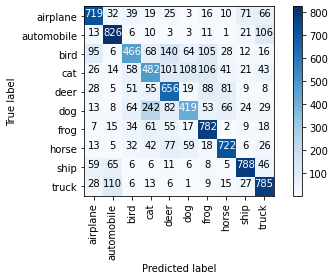

In [ ]:


# Best: 0.667320 using {'batch_size': 64, 'conv_filters': [64], 'conv_stack': 2, 'dense_layer_sizes': [512, 256], 
#                      'epochs': 10, 'init': 'he_normal', 'kernel_size': (3, 3), 'optimizer': ['adam']}


batch_size = 64 #grid_result.best_params_['batch_size']
conv_filters = [64] #grid_result.best_params_['conv_filters']
conv_stack = 2 # grid_result.best_params_['conv_stack']
dense_layer_sizes =  [512, 256]  #grid_result.best_params_['dense_layer_sizes']
epochs = 10 #grid_result.best_params_['epochs']
optimizer = ['adam'] #grid_result.best_params_['optimizer']
kernel_size = (3, 3) #grid_result.best_params_['kernel_size']


model1 = create_model(conv_filters, conv_stack,
                 dense_layer_sizes,
                 kernel_size,
                 optimizer, init='he_normal')

history = model1.fit(x_train,y_train,
           epochs = epochs,
           batch_size = batch_size,
           validation_data=(x_test,y_test))

scores = model1.evaluate(x_test,y_test)

y_pred = model1.predict(x_test)


show_train_history(history)

show_confusion_matrix(y_test, y_pred)

print('Classification Report')
print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1), target_names=class_names))

print('classification accuracy = '+ str(scores[1]))


Using the best Hyperparamters from original data and applied on PCA


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               111616    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 245,514
Trainable params: 245,514
Non-trainable params: 0
_________________________________________________________________
None
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5

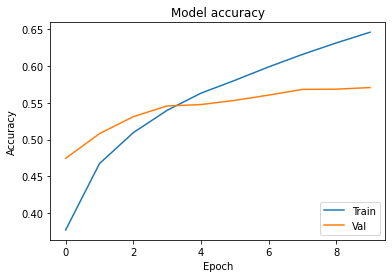

Classification Report
              precision    recall  f1-score   support

    airplane       0.65      0.65      0.65      1000
  automobile       0.65      0.69      0.67      1000
        bird       0.56      0.31      0.40      1000
         cat       0.37      0.46      0.41      1000
        deer       0.52      0.54      0.53      1000
         dog       0.48      0.40      0.44      1000
        frog       0.57      0.70      0.63      1000
       horse       0.65      0.64      0.65      1000
        ship       0.66      0.73      0.70      1000
       truck       0.62      0.59      0.60      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

classification accuracy = 0.5705999732017517


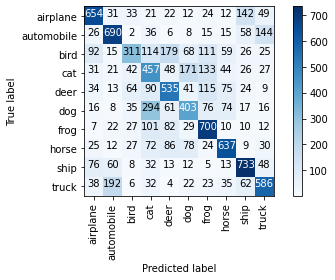

In [ ]:

# Best: 0.667320 using {'batch_size': 64, 'conv_filters': [64], 'conv_stack': 2, 'dense_layer_sizes': [512, 256], 
#                      'epochs': 10, 'init': 'he_normal', 'kernel_size': (3, 3), 'optimizer': ['adam']}



batch_size = 64 #grid_result.best_params_['batch_size']
dense_layer_sizes =  [512, 256]  #grid_result.best_params_['dense_layer_sizes']
epochs = 10 #grid_result.best_params_['epochs']
optimizer = 'adam' #grid_result.best_params_['optimizer']


i_dim= len(train_img_pca_50000[0])

model1 = model_creation(dense_layer_sizes,optimizer,i_dim)

history = model1.fit(train_img_pca_50000,y_train,
                   epochs = epochs,
                   batch_size = batch_size,
                   validation_data=(test_img_pca,y_test))

scores = model1.evaluate(test_img_pca,y_test)

y_pred = model1.predict(test_img_pca)

show_train_history(history)

show_confusion_matrix(y_test, y_pred)

print('Classification Report')
print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1), target_names=class_names))

print('classification accuracy = '+ str(scores[1]))


Hyperparameter Tuning on augmented data

In [ ]:


optimizers = [['adam'],['rmsprop']]
init = ['he_normal']
epochs = [10]
batches = [64,128]
cv_stack = [2]
kl_size = [(3,3),(5,5)]
cv_filters =[[64]]
dense_size_candidates = [[512, 256],[256,512,256],[128, 512]]

param_grid = dict(optimizer=optimizers,
                  epochs=epochs, 
                  batch_size=batches, 
                  init=init,
                  conv_filters=cv_filters,
                  conv_stack=cv_stack,
                  kernel_size=kl_size,
                  dense_layer_sizes=dense_size_candidates)

#%% Model and Grid creation & Running
model = KerasClassifier(build_fn=create_model, verbose=2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2,verbose=2)
grid_result = grid.fit(x_train_aug, y_train_aug)

#%% Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



Applying the best Hyperparamters for augmented data

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               33554944  
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)             

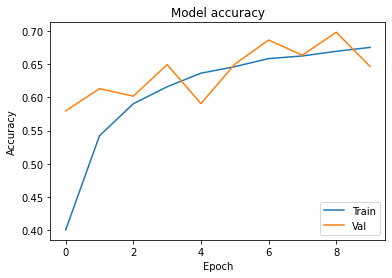

Classification Report
              precision    recall  f1-score   support

    airplane       0.83      0.52      0.64      1000
  automobile       0.86      0.77      0.81      1000
        bird       0.83      0.24      0.38      1000
         cat       0.62      0.33      0.43      1000
        deer       0.45      0.74      0.56      1000
         dog       0.64      0.58      0.61      1000
        frog       0.50      0.92      0.65      1000
       horse       0.77      0.68      0.72      1000
        ship       0.72      0.85      0.78      1000
       truck       0.69      0.84      0.76      1000

    accuracy                           0.65     10000
   macro avg       0.69      0.65      0.63     10000
weighted avg       0.69      0.65      0.63     10000

classification accuracy = 0.6466000080108643


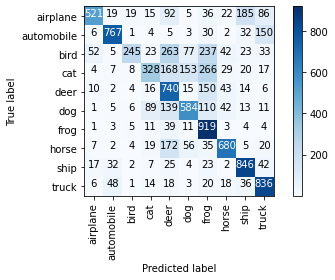

In [ ]:


# Best: 0.627730 using {'batch_size': 128, 'conv_filters': [64], 'conv_stack': 2, 'dense_layer_sizes': [512, 256],
#                      'epochs': 10, 'init': 'he_normal', 'kernel_size': (3, 3), 'optimizer': ['rmsprop']}


batch_size = 128 #grid_result.best_params_['batch_size']
conv_filters = [64] #grid_result.best_params_['conv_filters']
conv_stack = 2 #grid_result.best_params_['conv_stack']
dense_layer_sizes =  [512, 256] #grid_result.best_params_['dense_layer_sizes']
epochs= 10 #grid_result.best_params_['epochs']
optimizer = ['rmsprop'] #grid_result.best_params_['optimizer']
kernel_size = (3, 3) #grid_result.best_params_['kernel_size']


model1 = create_model(conv_filters, conv_stack,
                 dense_layer_sizes,
                 kernel_size,
                 optimizer, init='he_normal')

history = model1.fit(x_train_aug,y_train_aug,
           epochs = epochs,
           batch_size = batch_size,
           validation_data=(x_test,y_test))

scores = model1.evaluate(x_test,y_test)

y_pred = model1.predict(x_test)

show_train_history(history)

show_confusion_matrix(y_test, y_pred)

print('Classification Report')
print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1), target_names=class_names))

print('classification accuracy = '+ str(scores[1]))


Using the best Hyperparamters from augmented data and applied on feature extraction autoencoder

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 4,328,714
Trainable params: 4,328,714
Non-trainable params: 0
_________________________________________________________________
None
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 1

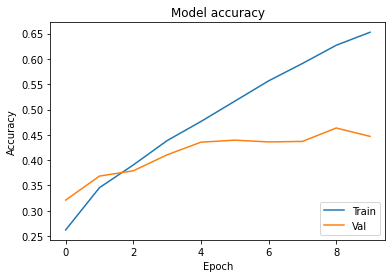

Classification Report
              precision    recall  f1-score   support

    airplane       0.43      0.55      0.49      1000
  automobile       0.51      0.64      0.57      1000
        bird       0.35      0.21      0.27      1000
         cat       0.32      0.20      0.25      1000
        deer       0.50      0.18      0.27      1000
         dog       0.38      0.34      0.36      1000
        frog       0.38      0.72      0.50      1000
       horse       0.57      0.48      0.52      1000
        ship       0.50      0.73      0.59      1000
       truck       0.53      0.41      0.46      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.43     10000
weighted avg       0.45      0.45      0.43     10000

classification accuracy = 0.44679999351501465
1 loop, best of 1: 6.1 s per loop


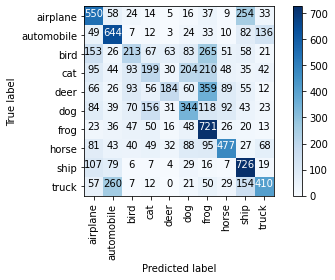

In [ ]:

%%timeit -n 1 -r 1
# Best: 0.627730 using {'batch_size': 128, 'conv_filters': [64], 'conv_stack': 2, 'dense_layer_sizes': [512, 256],
#                      'epochs': 10, 'init': 'he_normal', 'kernel_size': (3, 3), 'optimizer': ['rmsprop']}


dense_layer_sizes = [512, 256] #grid_result.best_params_['dense_layer_sizes']
optimizer = 'rmsprop'#grid_result.best_params_['optimizer']
batch_size = 128 #grid_result.best_params_['batch_size']
epochs= 10 # grid_result.best_params_['epochs']
i_dim= len(gist_train_ae_flat[0])

model1 = model_creation(dense_layer_sizes,optimizer,i_dim)

history = model1.fit(gist_train_ae_flat,y_trainf,
                   epochs = epochs,
                   batch_size = batch_size,
                   validation_data=(gist_valid_ae_flat,y_validf))

scores = model1.evaluate(gist_test_ae_flat,y_test)

y_pred = model1.predict(gist_test_ae_flat)

show_train_history(history)

show_confusion_matrix(y_test, y_pred)

print('Classification Report')
print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1), target_names=class_names))

print('classification accuracy = '+ str(scores[1]))
